In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df=pd.read_csv('dataset/24-hours Delhi Power Consumption dataset.csv')

In [19]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [20]:
def assign_compensation_method(row):
    if row['is_holiday'] == 1:
        return 'Lower Power Supply'
    elif row['solar_generation'] > 200:
        return 'Increased Renewable Energy Integration'
    elif row['hour_of_day'] >= 18 and row['hour_of_day'] <= 22:
        return 'Peak Load Shifting'
    elif row['temperature'] > 35:
        return 'Increased Power Supply'
    else:
        return 'Normal Operation'

df['compensation_method'] = df.apply(assign_compensation_method, axis=1)

print(df[['timestamp', 'load', 'compensation_method']].head(10))


            timestamp   load                     compensation_method
0 2023-01-01 00:00:00  18493                        Normal Operation
1 2023-01-01 01:00:00  17090                        Normal Operation
2 2023-01-01 02:00:00  16052                        Normal Operation
3 2023-01-01 03:00:00  15356                        Normal Operation
4 2023-01-01 04:00:00  14936                        Normal Operation
5 2023-01-01 05:00:00  14884                        Normal Operation
6 2023-01-01 06:00:00  15314  Increased Renewable Energy Integration
7 2023-01-01 07:00:00  16591  Increased Renewable Energy Integration
8 2023-01-01 08:00:00  18271                        Normal Operation
9 2023-01-01 09:00:00  19470  Increased Renewable Energy Integration


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [22]:
X = df[['temperature', 'solar_generation', 'hour_of_day', 'load', 'is_holiday']]
y=df['compensation_method']
X_reg = df[['temperature', 'solar_generation', 'hour_of_day', 'is_holiday']]
y_reg = df['load']
le = LabelEncoder()
y = le.fit_transform(y)

In [23]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler

# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
# from keras.optimizers import Adam
# from keras.layers import BatchNormalization
# from keras.layers import Activation
#ann

# Normalize the data
scaler_reg = StandardScaler()
scaler_cls = StandardScaler()

X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)
X_train_scaled = scaler_cls.fit_transform(X_train)
X_test_scaled = scaler_cls.transform(X_test)



In [25]:
pip install keras-tuner --upgrade


Fold 1/5

LSTM - Fold 1 - MSE: 5838593.03
GRU - Fold 1 - MSE: 5333484.07

Fold 2/5

LSTM - Fold 2 - MSE: 5915450.02
GRU - Fold 2 - MSE: 5849895.53

Fold 3/5

LSTM - Fold 3 - MSE: 6457282.81
GRU - Fold 3 - MSE: 6359238.77

Fold 4/5

LSTM - Fold 4 - MSE: 5706668.53
GRU - Fold 4 - MSE: 5489234.87

Fold 5/5

LSTM - Fold 5 - MSE: 5024827.45
GRU - Fold 5 - MSE: 4957828.90

LSTM Final Results:
MSE: 5788564.37 (±459518.92)
MAE: 1819.19 (±87.16)
R2: 0.48 (±0.03)

GRU Final Results:
MSE: 5597936.42 (±476351.42)
MAE: 1775.34 (±81.70)
R2: 0.50 (±0.04)


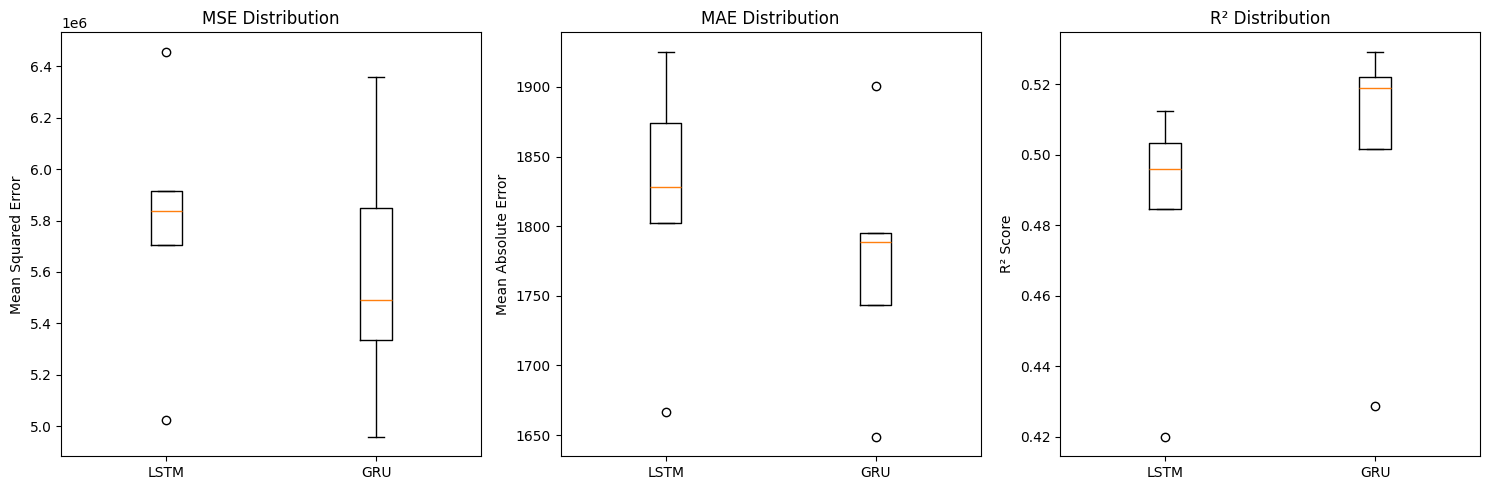

In [33]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define model creation functions with fixed hyperparameters
def create_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2):
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units//2, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_gru_model(input_shape, gru_units=64, dropout_rate=0.2):
    model = Sequential([
        GRU(gru_units, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        GRU(gru_units//2, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

# Initialize K-Fold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage for results
cv_results = {
    'lstm': {'mse': [], 'mae': [], 'r2': []},
    'gru': {'mse': [], 'mae': [], 'r2': []}
}

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_reg_train_scaled)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # Split data using .iloc to ensure proper indexing
    X_train_fold = X_reg_train_scaled[train_idx]
    y_train_fold = y_reg_train.iloc[train_idx]
    X_val_fold = X_reg_train_scaled[val_idx]
    y_val_fold = y_reg_train.iloc[val_idx]
    
    # Reshape for LSTM/GRU input
    X_train_fold_reshaped = X_train_fold.reshape((X_train_fold.shape[0], 1, X_train_fold.shape[1]))
    X_val_fold_reshaped = X_val_fold.reshape((X_val_fold.shape[0], 1, X_val_fold.shape[1]))
    
    # Train and evaluate LSTM
    lstm_model = create_lstm_model((1, X_reg_train_scaled.shape[1]))
    lstm_history = lstm_model.fit(
        X_train_fold_reshaped, y_train_fold,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_fold_reshaped, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Train and evaluate GRU
    gru_model = create_gru_model((1, X_reg_train_scaled.shape[1]))
    gru_history = gru_model.fit(
        X_train_fold_reshaped, y_train_fold,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_fold_reshaped, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Evaluate models
    lstm_pred = lstm_model.predict(X_val_fold_reshaped, verbose=0)
    gru_pred = gru_model.predict(X_val_fold_reshaped, verbose=0)
    
    # Store metrics for LSTM
    cv_results['lstm']['mse'].append(mean_squared_error(y_val_fold, lstm_pred))
    cv_results['lstm']['mae'].append(mean_absolute_error(y_val_fold, lstm_pred))
    cv_results['lstm']['r2'].append(r2_score(y_val_fold, lstm_pred))
    
    # Store metrics for GRU
    cv_results['gru']['mse'].append(mean_squared_error(y_val_fold, gru_pred))
    cv_results['gru']['mae'].append(mean_absolute_error(y_val_fold, gru_pred))
    cv_results['gru']['r2'].append(r2_score(y_val_fold, gru_pred))
    
    # Print fold results
    print(f"\nLSTM - Fold {fold + 1} - MSE: {cv_results['lstm']['mse'][-1]:.2f}")
    print(f"GRU - Fold {fold + 1} - MSE: {cv_results['gru']['mse'][-1]:.2f}")

# Print final results
for model in ['lstm', 'gru']:
    print(f"\n{model.upper()} Final Results:")
    print(f"MSE: {np.mean(cv_results[model]['mse']):.2f} (±{np.std(cv_results[model]['mse']):.2f})")
    print(f"MAE: {np.mean(cv_results[model]['mae']):.2f} (±{np.std(cv_results[model]['mae']):.2f})")
    print(f"R2: {np.mean(cv_results[model]['r2']):.2f} (±{np.std(cv_results[model]['r2']):.2f})")

# Visualize results
plt.figure(figsize=(15, 5))

# Plot MSE
plt.subplot(131)
plt.boxplot([cv_results['lstm']['mse'], cv_results['gru']['mse']], labels=['LSTM', 'GRU'])
plt.title('MSE Distribution')
plt.ylabel('Mean Squared Error')

# Plot MAE
plt.subplot(132)
plt.boxplot([cv_results['lstm']['mae'], cv_results['gru']['mae']], labels=['LSTM', 'GRU'])
plt.title('MAE Distribution')
plt.ylabel('Mean Absolute Error')

# Plot R²
plt.subplot(133)
plt.boxplot([cv_results['lstm']['r2'], cv_results['gru']['r2']], labels=['LSTM', 'GRU'])
plt.title('R² Distribution')
plt.ylabel('R² Score')

plt.tight_layout()
plt.savefig('output/model_comparison_boxplots.svg')
plt.show()

In [ ]:
# get the models


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [30]:
# best gru model
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]
best_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51456     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Reshape the test set for LSTM/GRU input
X_reg_test_reshaped = X_reg_test_scaled.reshape((X_reg_test_scaled.shape[0], 1, X_reg_test_scaled.shape[1]))

# Make predictions using the LSTM model
lstm_test_pred = lstm_model.predict(X_reg_test_reshaped)
lstm_mse = mean_squared_error(y_reg_test, lstm_test_pred)
lstm_mae = mean_absolute_error(y_reg_test, lstm_test_pred)
lstm_r2 = r2_score(y_reg_test, lstm_test_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = np.mean(np.abs((y_reg_test - lstm_test_pred.flatten()) / y_reg_test)) * 100

# Make predictions using the GRU model
gru_test_pred = gru_model.predict(X_reg_test_reshaped)
gru_mse = mean_squared_error(y_reg_test, gru_test_pred)
gru_mae = mean_absolute_error(y_reg_test, gru_test_pred)
gru_r2 = r2_score(y_reg_test, gru_test_pred)
gru_rmse = np.sqrt(gru_mse)
gru_mape = np.mean(np.abs((y_reg_test - gru_test_pred.flatten()) / y_reg_test)) * 100

# Print results for LSTM
print("LSTM Model Test Results:")
print(f"Mean Squared Error: {lstm_mse:.2f}")
print(f"Mean Absolute Error: {lstm_mae:.2f}")
print(f"R^2 Score: {lstm_r2:.2f}")
print(f"Root Mean Squared Error: {lstm_rmse:.2f}")
print(f"Mean Absolute Percentage Error: {lstm_mape:.2f}%")

# Print results for GRU
print("\nGRU Model Test Results:")
print(f"Mean Squared Error: {gru_mse:.2f}")
print(f"Mean Absolute Error: {gru_mae:.2f}")
print(f"R^2 Score: {gru_r2:.2f}")
print(f"Root Mean Squared Error: {gru_rmse:.2f}")
print(f"Mean Absolute Percentage Error: {gru_mape:.2f}%")

82/82 [==============================] - 0s 880us/step
LSTM Model Test Results:
Mean Squared Error: 6058127.08
Mean Absolute Error: 1834.84
R^2 Score: 0.50
Root Mean Squared Error: 2461.33
Mean Absolute Percentage Error: 9.83%

GRU Model Test Results:
Mean Squared Error: 5977335.93
Mean Absolute Error: 1819.33
R^2 Score: 0.50
Root Mean Squared Error: 2444.86
Mean Absolute Percentage Error: 9.73%
